In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

#df_train.info()
#df_train.tail().T

#df_train.isnull().sum()
#df_train.nunique()
#df_train.describe().T

In [4]:
def prepare_data(df):

    # Make the column names lower-case and uniform
    df.columns = df.columns.str.lower()

    # Drop id column
    df.drop('id', axis=1, inplace=True)
    
    # Logarithm transformation to reduce spread
    #log_cols = ['density_total','atomicweight_average']
    #df[log_cols] = np.log1p(df[log_cols])
    
    return df

df_train = prepare_data(df_train)
df_test = prepare_data(df_test)

In [5]:
df_train.corr().style.background_gradient(cmap='coolwarm').format(precision=2)


,allelectrons_total,density_total,allelectrons_average,val_e_average,atomicweight_average,ionenergy_average,el_neg_chi_average,r_vdw_element_average,r_cov_element_average,zaratio_average,density_average,hardness
allelectrons_total,1.00,0.62,0.07,0.07,0.08,0.03,0.04,0.04,0.02,0.03,0.06,-0.06
density_total,0.62,1.00,0.36,0.08,0.36,-0.10,-0.08,0.20,0.24,-0.09,0.34,-0.16
allelectrons_average,0.07,0.36,1.00,0.00,0.99,-0.36,-0.32,0.55,0.69,-0.33,0.80,-0.40
val_e_average,0.07,0.08,0.00,1.00,0.00,0.45,0.55,0.35,0.19,0.09,-0.07,0.16
atomicweight_average,0.08,0.36,0.99,0.00,1.00,-0.36,-0.32,0.53,0.67,-0.33,0.80,-0.40
ionenergy_average,0.03,-0.10,-0.36,0.45,-0.36,1.00,0.77,0.08,-0.24,0.64,-0.36,0.20
el_neg_chi_average,0.04,-0.08,-0.32,0.55,-0.32,0.77,1.00,0.12,-0.17,0.44,-0.32,0.29
r_vdw_element_average,0.04,0.20,0.55,0.35,0.53,0.08,0.12,1.00,0.81,0.00,0.44,-0.06
r_cov_element_average,0.02,0.24,0.69,0.19,0.67,-0.24,-0.17,0.81,1.00,-0.22,0.57,-0.19
zaratio_average,0.03,-0.09,-0.33,0.09,-0.33,0.64,0.44,0.00,-0.22,1.00,-0.31,0.06


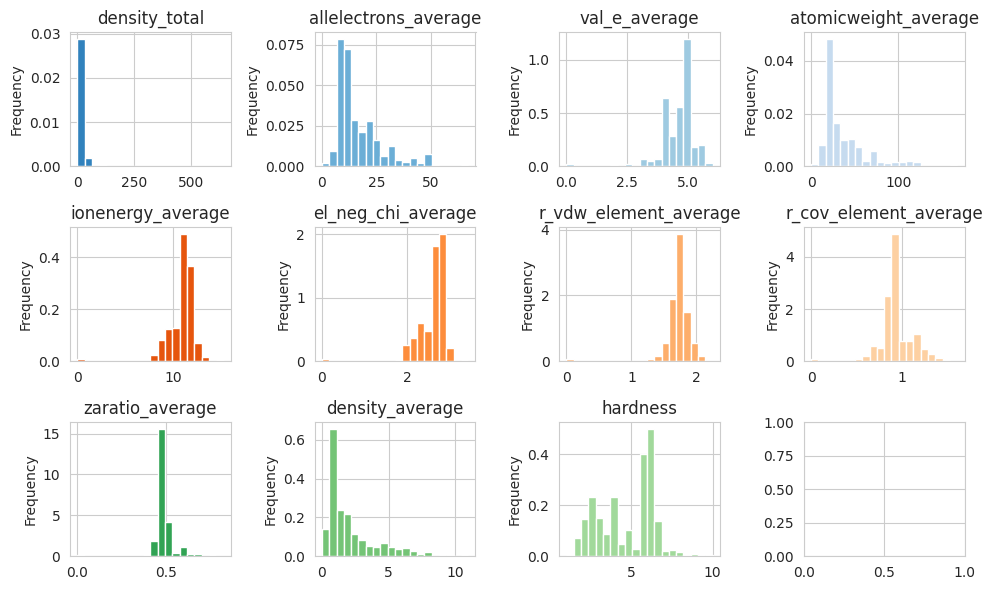

In [6]:
%matplotlib inline

cmap = plt.get_cmap("tab20c")
colors = cmap(range(df_train.columns[1:].shape[0]))

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(10, 6))
axs = axs.flatten()
    
for idx, col in enumerate(df_train.columns[1:]):
    df_train[col].plot.hist(ax=axs[idx], density=True, bins=20, color=colors[idx])
    axs[idx].set_title(col)
    
plt.tight_layout()

hardness                 1.000000
atomicweight_average     0.402948
allelectrons_average     0.400496
density_average          0.360780
el_neg_chi_average       0.290352
ionenergy_average        0.203203
r_cov_element_average    0.189111
val_e_average            0.161715
density_total            0.161524
allelectrons_total       0.061687
r_vdw_element_average    0.061402
zaratio_average          0.055248
dtype: float64

Text(0.5, 1.0, 'Correlation: Top 10 numerical features')

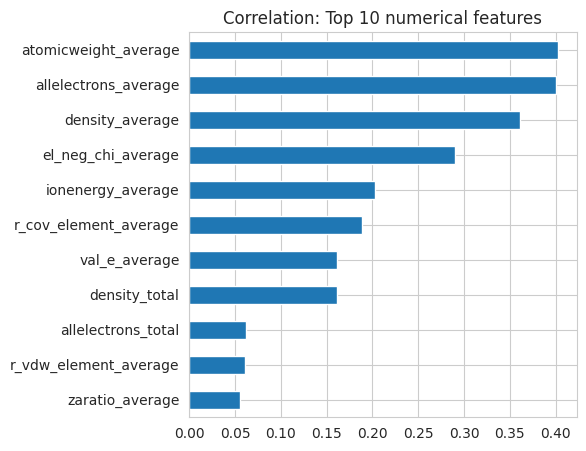

In [7]:
corr = df_train.corrwith(df_train.hardness).abs().sort_values(ascending=False)
display(corr)

fig, ax = plt.subplots(figsize=(5,5))
corr[1:][::-1].plot.barh(ax=ax)
ax.set_title('Correlation: Top 10 numerical features')

In [8]:
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = np.log1p(df_train.hardness.values)
y_val = np.log1p(df_val.hardness.values)

del df_train['hardness']
del df_val['hardness']


In [9]:
# encoding
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_val = scaler.transform(df_val)
X_test = scaler.transform(df_test)

In [10]:
# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[-1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Custom Median Absolute Error metric
def medae_keras(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    medae = tfp.stats.percentile(absolute_errors, 50.0, interpolation='linear')
    return medae

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.MeanAbsoluteError()

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[medae_keras])

EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_medae_keras', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/100
160/160 [==============================] - 2s 5ms/step - loss: 0.3702 - medae_keras: 0.3189 - val_loss: 0.2445 - val_medae_keras: 0.1605
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2252 - medae_keras: 0.1555 - val_loss: 0.2292 - val_medae_keras: 0.1555
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2189 - medae_keras: 0.1495 - val_loss: 0.2268 - val_medae_keras: 0.1440
Epoch 4/100
160/160 [==============================] - 0s 3ms/step - loss: 0.2151 - medae_keras: 0.1443 - val_loss: 0.2195 - val_medae_keras: 0.1416
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2129 - medae_keras: 0.1455 - val_loss: 0.2169 - val_medae_keras: 0.1388
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 0.2092 - medae_keras: 0.1396 - val_loss: 0.2137 - val_medae_keras: 0.1375
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 0.2073 - medae_keras: 0.1413 - 

In [11]:
def plot_metrics(history):
  metrics = ['loss', 'medae_keras']
  plt.figure(figsize=(10,5))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    plt.legend()     

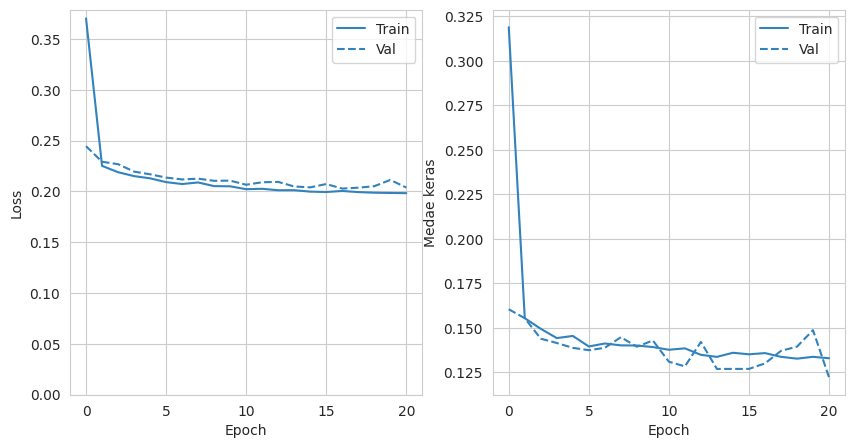

In [12]:
plot_metrics(history)


In [13]:
# Prediction
y_fit = np.expm1(model.predict(X_train, batch_size=BATCH_SIZE))
y_pred = np.expm1(model.predict(X_val, batch_size=BATCH_SIZE))

y_train = np.expm1(y_train)
y_val = np.expm1(y_val)

# Evaluation
print("Median Absolute Error (Training):", np.median(np.abs(y_train - y_fit)))
print("Median Absolute Error (Validation):", np.median(np.abs(y_val - y_pred)))

98/98 [==============================] - 0s 1ms/step
Median Absolute Error (Training): 1.3603901863098145
Median Absolute Error (Validation): 1.3599648475646973


In [14]:
submissions = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

y_submission = model.predict(X_test, batch_size=BATCH_SIZE)
y_submission = np.expm1(y_submission)
submissions['Hardness'] = y_submission

submissions.to_csv('/kaggle/working/baseline.csv', index=False)

submissions.head()

217/217 [==============================] - 0s 1ms/step


,id,Hardness
0,10407,4.605868
1,10408,6.648811
2,10409,6.024653
3,10410,5.991707
4,10411,5.050882
